# Environment Check

Run this cell first to verify your environment is set up correctly:

# Chapter 1: Training Loop Fundamentals

---

**License**: Apache 2.0  
**Original Work**: [Deep Learning for Biology](https://github.com/deep-learning-for-biology/dlfb) by Charles Ravarani and Natasha Latysheva  
**This Notebook**: Additional Chapter 1 content by Brandon Nieves

Based on the Deep Learning for Biology book and companion repository.

---

In [ ]:
import sys
import platform
from pathlib import Path

print("=" * 60)
print("ENVIRONMENT DIAGNOSTICS")
print("=" * 60)

# 1. Python version and location
print(f"\n✓ Python Version: {sys.version.split()[0]}")
print(f"✓ Python Executable: {sys.executable}")

# 2. Check if using venv
in_venv = sys.prefix != sys.base_prefix
print(f"✓ Using Virtual Environment: {'YES ✓' if in_venv else 'NO ✗'}")
if in_venv:
    print(f"  Virtual Env Path: {sys.prefix}")

# 3. Kernel information
try:
    import ipykernel
    print(f"\n✓ IPython Kernel Version: {ipykernel.__version__}")
except ImportError:
    print("\n✗ IPython Kernel: Not found")

# 4. Check key packages
print("\n" + "=" * 60)
print("INSTALLED PACKAGES")
print("=" * 60)

packages_to_check = [
    'dlfb',
    'numpy',
    'pandas', 
    'matplotlib',
    'seaborn',
    'sklearn',
    'jax',
    'flax',
    'optax',
    'jupyter',
]

for package in packages_to_check:
    try:
        mod = __import__(package)
        version = getattr(mod, '__version__', 'unknown')
        print(f"✓ {package:15s} {version}")
    except ImportError:
        print(f"✗ {package:15s} NOT INSTALLED")

# 5. System info
print("\n" + "=" * 60)
print("SYSTEM INFO")
print("=" * 60)
print(f"✓ OS: {platform.system()} {platform.release()}")
print(f"✓ Machine: {platform.machine()}")
print(f"✓ Working Directory: {Path.cwd()}")

print("\n" + "=" * 60)
print("STATUS: Environment is ready!" if in_venv else "WARNING: Not using venv!")
print("=" * 60)

---

# Colab Setup (Skip if running locally)

To run this notebook on Colab, follow these setup steps:

1. **Clone the `dlfb` library** (Colab only)  
   First, clone the repository that contains the `dlfb` library.

2. **Install dependencies**  
   Once the library is cloned, install the required dependencies.

In [ ]:
%%bash
curl -LsSf https://astral.sh/uv/install.sh | sh && \
export PATH="/root/.local/bin:${PATH}" && \
uv pip compile ./requirements/{base,dlfb,proteins,gpu}.txt \
  --color never \
  --constraint ./requirements/constraints.txt | \
uv pip install -r - --system

3. **Provision the datasets**  
   You’ll then need to access and download the necessary datasets for this chapter.

In [ ]:
# NOTE: exclude models with '--no-models' flag
!dlfb-provision --chapter proteins

4. **Load the `dlfb` package**  
   Finally, load the `dlfb` package.  
   - ⚠️ Note: Loading can sometimes be finicky. If you encounter issues, simply **restart the runtime**. All previously downloaded data and installed packages will persist, so you can re-run the load step without repeating everything.

In [ ]:
# Toggle JAX_DISABLE_JIT to True for easier debugging
%env JAX_DISABLE_JIT=False

try:
  import dlfb
except ImportError as exc:
  # NOTE: Packages installed in editable mode are not immediately
  #       recognized by Colab (https://stackoverflow.com/a/63312333).
  import site
  site.main()
  import dlfb

from dlfb.utils.display import display

# Anatomy of a Training Loop
- Defining a dataset
- Defining a model
- Creating a training state
- Defining a loss function
- Defining the training set
- Handling auxiliary outputs in the loss function
- Defining the training loop
    - define a model, compute a loss, update parameters, and repeat

## Defining a dataset

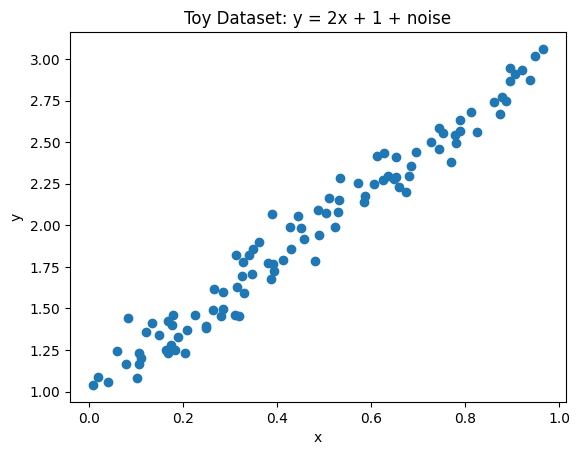

In [15]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from flax import linen as nn

# In JAX, randomness is handled explicitly by passing a random key.
# We create a key here to seed the random number generator
rng = jax.random.PRNGKey(42)

# Generate toy data: x values uniformly sampled between 0 and 1.
rng, rng_data, rng_noise = jax.random.split(rng, 3)
x_data = jax.random.uniform(rng_data, shape=(100, 1))

# Add Gaussian noise
noise = 0.1 * jax.random.normal(rng_noise, shape=(100, 1))

# Define target:y = 2x + 1 + noise
y_data = 2 * x_data + 1 + noise

# Visualize the noisy linear relationship
plt.scatter(x_data, y_data)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Toy Dataset: y = 2x + 1 + noise")
plt.show()

## Defining a model

In [3]:
class LinearModel(nn.Module):
    @nn.compact
    def __call__(self, x):
        # Applies a single dense (fully connected) layer with 1 output neuron
        # That is, it computes y = xW + b, where the output has dimension 1
        return nn.Dense(features=1)(x)

In [4]:
from dlfb.utils.display import print_short_dict

model = LinearModel()
rng = jax.random.PRNGKey(42)
variables = model.init(rng, jnp.ones((1, 1)))
print_short_dict(variables)

{'params': {'Dense_0': {'kernel': Array([[-0.5220277]], dtype=float32), 'bias':
Array([0.], dtype=float32)}}}


## Creating a training state

In [5]:
import optax
from flax.training import train_state

# Define an optimizer - here we use Adam with a learning rate of 1.0.
# (Note: in most real settings you'd use a smaller learning rate like 1e-3)
tx = optax.adam(1.0)

# Create the training state
state = train_state.TrainState.create(
    apply_fn=model.apply, # The model's forward pass function
    params=variables["params"], # The initialized model parameters
    tx=tx, # The optimizer
)
    

## Defining a loss function

In [6]:
def calculate_loss(params, x, y):
    # Run a forward pass of the model to get predictions
    predictions = model.apply({"params": params}, x)

    # Compute MSE loss
    return jnp.mean((predictions - y) ** 2)

In [7]:
loss = calculate_loss(variables["params"], x_data, y_data)
print(f"Loss: {loss:.4f}")

Loss: 5.2768


## Defining the training step

In [8]:
@jax.jit
def train_step(state, x, y):
    # Compute the loss and it's gradients with respect to the parameters
    loss, grads = jax.value_and_grad(compute_loss)(state.params, x, y)

    # Apply gradient updates.
    new_state = state.apply_gradients(grads=grads)

    return new_state, loss

In [9]:
@jax.jit
def train_step(state, x, y):
    def calculate_loss(params):
        # state, x and y are not part of the function signature but are accessed
        predictions = state.apply_fn({"params": params}, x)
        return jnp.mean((predictions - y) ** 2)

    loss, grads = jax.value_and_grad(calculate_loss)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

## Handling auxiliary outputs in the loss function

In [11]:
@jax.jit
def train_step(state, x, y):
    def calculate_loss(params):
        predictions = state.apply_fn({"params": params}, x)
        loss = jnp.mean((predictions - y) ** 2)
        return loss, predictions # Return both loss and preds (aux info).

    (loss, predictions), grads = jax.value_and_grad(calculate_loss, has_aux=True)(state.params)

    state = state.apply_gradients(grads=grads)
    return state, (loss, predictions)

## Defining the training loop

In [12]:
num_epochs = 150 # Number of full passes through the training data

for epoch in range(num_epochs):
    state, (loss, _) = train_step(state, x_data, y_data)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

Epoch 0, Loss: 5.2768
Epoch 10, Loss: 0.9498
Epoch 20, Loss: 0.1091
Epoch 30, Loss: 0.0845
Epoch 40, Loss: 0.0283
Epoch 50, Loss: 0.0258
Epoch 60, Loss: 0.0106
Epoch 70, Loss: 0.0105
Epoch 80, Loss: 0.0106
Epoch 90, Loss: 0.0102
Epoch 100, Loss: 0.0101
Epoch 110, Loss: 0.0100
Epoch 120, Loss: 0.0100
Epoch 130, Loss: 0.0100
Epoch 140, Loss: 0.0100


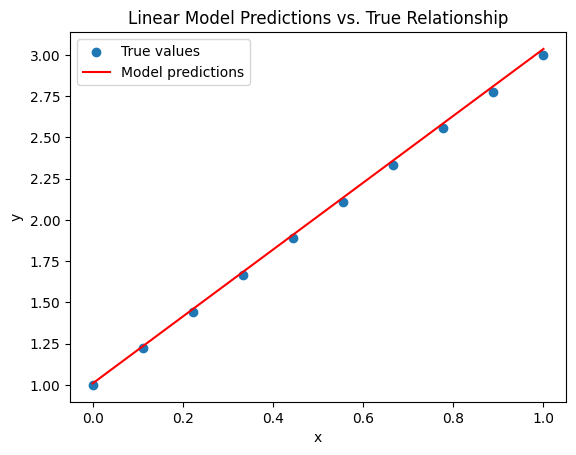

In [13]:
# Generate test data (x values between 0 and 1).
x_test = jnp.linspace(0, 1, 10).reshape(-1, 1)
y_test = 2 * x_test + 1 # Ground truth: linear function without noise

# Get model predictions
y_pred = state.apply_fn({"params": state.params}, x_test)

plt.scatter(x_test, y_test, label="True values")
plt.plot(x_test, y_pred, color="red", label="Model predictions")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Linear Model Predictions vs. True Relationship")
plt.show()